# Variable Selection for NFL Big Data Bowl 2025

## games.csv

gameId - key variable for games

week - weeks 1-9

homeTeamAbbr - 3 letter abbreviation of home team

visitorTeamAbbr - 3 letter abbreviation of home team

homeFinalScore - final score of home team.

visitorFinalScore - final score of away team.

## player_play.csv

gameId - key variable for games

playId - key variable for each play in a game

nflID - key variable for each player

teamAbbr - 3 letter abbreviation of home team

inMotionAtBallSnap - Boolean

motionSinceLineset - Boolean indicating whether the player went in motion after they were initially set at the line on this play

wasRunningRoute -  Boolean indicating if the player was running a route on this play (Boolean)

routeRan - The name of the route ran by the player on this play (text)


## players.csv

nflId - key variable for players

position - official player position (text)

displayName - player name, useful for visualizations?


## plays.csv

gameId - key variable for identifiying games

playId - key variable for identifying games

quarter - game quarter (numeric)

down - Down (numeric)

yardsToGo - distance needed for a first down (numeric)

possessionTeam - Team abbr of team on offense with possession of the ball (text)

defensiveTeam - Team abbr of team on defense (text)

yardlineSide - 3-letter team code corresponding to line of scrimmage (text)

yardlineNumber: Yard line at line-of-scrimmage (numeric)

gameClock: Time on clock of play (MM:SS)

preSnapHomeScore: Home score prior to the play (numeric)

preSnapVisitorScore: Visiting team score prior to the play (numeric)

playNullifiedByPenalty: Whether or not an accepted penalty on the play cancels the play outcome. Y stands for yes and N stands for no. (text) 

absoluteYardlineNumber: Distance from end zone for possession team (numeric)

offenseFormation: Formation used by possession team (text)

receiverAlignment: Enumerated as 0x0, 1x0, 1x1, 2x0, 2x1, 2x2, 3x0, 3x1, 3x2 (text)

qbSpike: Boolean indicating whether the play was a QB Spike (Boolean)

qbKneel: Whether or not the play was a QB Kneel (numeric)


# tracking_week_*.csv

gameId - key variable for identifying games

playId - key variable for identifying plays in a game

nflId - key variable for identifying players.

frameType: Whether frame was before, during or after snap. (text)

displayName: Player name (text)

frameId: Frame identifier for each play, starting at 1 (numeric)

time: Time stamp of play (time, yyyy-mm-dd, hh:mm:ss)

club: Team abbrevation of corresponding player (text)

playDirection: Direction that the offense is moving (left or right)

x: Player position along the long axis of the field, 0 - 120 yards.

y: Player position along the short axis of the field, 0 - 53.3 yards.

s: Speed in yards/second (numeric)

a: Acceleration in yards/second^2 (numeric)

dis: Distance traveled from prior time point, in yards (numeric)

o: Player orientation (deg), 0 - 360 degrees (numeric)

dir: Angle of player motion (deg), 0 - 360 degrees (numeric)

event: Tagged play details, including moment of ball snap, pass release, pass catch, tackle, etc (text)

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import logging

In [3]:


# Define the columns to load from each CSV file
player_play_columns = ['gameId', 'playId', 'nflId', 'wasRunningRoute', 'inMotionAtBallSnap', 'motionSinceLineset']
plays_columns = ['gameId', 'playId', 'playNullifiedByPenalty', 'gameClock', 'offenseFormation', 'receiverAlignment', 'quarter', 'down', 'yardsToGo', 'preSnapHomeScore', 'preSnapVisitorScore', 'absoluteYardlineNumber']
tracking_columns = ['gameId', 'playId', 'nflId', 'frameId', 'frameType', 'event', 'x', 'y', 's', 'a', 'dis', 'o', 'dir', 'playDirection']

# Load the player_play.csv data into a DataFrame with selected columns
player_play_df = pd.read_csv('Data/player_play.csv', usecols=player_play_columns)

# Load the plays.csv data into a DataFrame with selected columns
plays_df = pd.read_csv('Data/plays.csv', usecols=plays_columns)

# Merge the player_play_df and plays_df on the key variables 'gameId' and 'playId'
merged_df = pd.merge(player_play_df, plays_df, on=['gameId', 'playId'])

print(merged_df.head())
print(merged_df.columns)

# Load the tracking data for weeks 1-6 into DataFrames with selected columns
tracking_dfs = []
for week in range(1, 7):
    df = pd.read_csv(f'Data/tracking_week_{week}.csv', usecols=tracking_columns)
    tracking_dfs.append(df)

# Concatenate all the weekly DataFrames into a single DataFrame
tracking_df = pd.concat(tracking_dfs, ignore_index=True)

# Merge merged_df and tracking_df on the key variables 'gameId', 'playId', and 'nflId'
final_merged_df = pd.merge(merged_df, tracking_df, on=['gameId', 'playId', 'nflId'])

# Display the merged DataFrame
print(final_merged_df.head())


       gameId  playId  nflId inMotionAtBallSnap motionSinceLineset  \
0  2022090800      56  35472              False              False   
1  2022090800      56  42392              False              False   
2  2022090800      56  42489              False               True   
3  2022090800      56  44875              False              False   
4  2022090800      56  44985              False              False   

   wasRunningRoute  quarter  down  yardsToGo gameClock  preSnapHomeScore  \
0              NaN        1     1         10     15:00                 0   
1              NaN        1     1         10     15:00                 0   
2              1.0        1     1         10     15:00                 0   
3              NaN        1     1         10     15:00                 0   
4              1.0        1     1         10     15:00                 0   

   preSnapVisitorScore playNullifiedByPenalty  absoluteYardlineNumber  \
0                    0                      N    

In [5]:
# Save the final_merged_df DataFrame to a CSV file
final_merged_df.to_csv('final_merged_data.csv', index=False)


In [4]:
df = pd.read_csv('final_merged_data.csv')


In [6]:
df = final_merged_df

In [5]:
############################################################
# 1) LOAD + FILTER + ENCODE
############################################################


# Suppose we only keep rows for players who "wasRunningRoute" == 1.0 
df = df[df['wasRunningRoute'] == 1.0]

# Fill NA booleans
df['inMotionAtBallSnap'] = df['inMotionAtBallSnap'].fillna(False).infer_objects(copy=False)
df['motionSinceLineset'] = df['motionSinceLineset'].fillna(False).infer_objects(copy=False)

# Exclude plays nullified by penalty
df = df[df['playNullifiedByPenalty'] == 'N']

# Convert gameClock to total seconds
def convert_game_clock_to_seconds(df):
    time_parts = df['gameClock'].str.split(':', expand=True).astype(int)
    return time_parts[0] * 60 + time_parts[1]

df['gameClock'] = convert_game_clock_to_seconds(df)

# Sort
df = df.sort_values(by=['gameId', 'playId', 'frameId']).reset_index(drop=True)

# One-hot encode key categoricals
categorical_cols = ['offenseFormation', 'receiverAlignment', 'playDirection']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Numeric + dummy feature columns
base_features = [
    'inMotionAtBallSnap',
    'motionSinceLineset',
    'wasRunningRoute',
    'quarter',
    'down',
    'yardsToGo',
    'gameClock',
    'preSnapHomeScore',
    'preSnapVisitorScore',
    'absoluteYardlineNumber',
    'x',
    'y',
    's',
    'a',
    'dis',
    'o',
    'dir'
]
dummy_columns = [
    c for c in df.columns
    if c.startswith('offenseFormation_')
    or c.startswith('receiverAlignment_')
    or c.startswith('playDirection_')
]
feature_cols = base_features + dummy_columns

C:\Users\ellio\AppData\Local\Temp\ipykernel_23560\2465396072.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['inMotionAtBallSnap'] = df['inMotionAtBallSnap'].fillna(False).infer_objects(copy=False)
C:\Users\ellio\AppData\Local\Temp\ipykernel_23560\2465396072.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['motionSinceLineset'] = df['motionSinceLineset'].fillna(False).infer_objects(copy=False)


In [23]:
# !pip install pandas numpy scikit-learn tensorflow keras





# Standardize the data
#scaler = StandardScaler()
#df[base_features] = scaler.fit_transform(df[base_features])

logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')

############################################################
# 2) BUILD SEQUENCES (Shift x,y so snap is at (0,0))
############################################################

def build_sequences_for_play(play_df, feature_cols):
    """
    Given all data for a single (gameId, playId, nflId),
    return (input_sequence, output_sequence) with x,y shifted
    so the snap location is (0,0).
    """
    # Sort by frameId
    play_df = play_df.sort_values('frameId')

    # 1) Identify frames that are BEFORE_SNAP *or* the SNAP frame itself
    before_snap_df = play_df[
        (play_df['frameType'] == 'BEFORE_SNAP') | (play_df['frameType'] == 'SNAP')
    ]
    
    if len(before_snap_df) == 0:
        return None

    # 2) Identify frames from SNAP to pass_outcome_...
    snap_index = play_df[play_df['event'] == 'ball_snap'].index
    catch_index = play_df[play_df['event'].fillna('').str.contains('pass_outcome_')].index
    
    if len(snap_index) == 0 or len(catch_index) == 0:
        return None
    
    snap_frame_id = snap_index[0]
    catch_frame_id = catch_index[0]
    
    if catch_frame_id <= snap_frame_id:
        return None
    
    # snap_df: frames from the moment of snap through pass_outcome
    snap_df = play_df.loc[snap_frame_id:catch_frame_id]

    # 3) Do not shift x,y; use original coordinates
    before_snap_copy = before_snap_df.copy()
    snap_copy = snap_df.copy()

    # 4) Build X_before_snap from the (possibly) extended before-snap portion
    X_before_snap = before_snap_copy[feature_cols].values

    # 5) Build Y_route => future route after snap, shape [time_steps, 2]
    Y_route = snap_copy[['x','y']].values
    
    return X_before_snap, Y_route

def build_dataset(df, feature_cols):
    X_list, Y_list = [], []
    grouped = df.groupby(['gameId','playId','nflId'])
    
    for (gId, pId, nId), play_df in grouped:
        result = build_sequences_for_play(play_df, feature_cols)
        if result is not None:
            X_seq, Y_seq = result
            X_list.append(X_seq)
            Y_list.append(Y_seq)
            logging.debug("Added sequence for gameId=%s, playId=%s, nflId=%s", gId, pId, nId)
    
    logging.info("Total number of sequences built: %d", len(X_list))
    return X_list, Y_list

X_list, Y_list = build_dataset(df, feature_cols)
print(f"Number of sequences built: {len(X_list)}")

############################################################
# 3) PAD SEQUENCES
############################################################

def pad_sequences(X_list, Y_list):
    max_len_in = max(seq.shape[0] for seq in X_list)
    max_len_out = max(seq.shape[0] for seq in Y_list)
    num_features = X_list[0].shape[1]
    
    X_padded = np.zeros((len(X_list), max_len_in, num_features), dtype=np.float32)
    Y_padded = np.zeros((len(Y_list), max_len_out, 2), dtype=np.float32)
    
    X_mask = np.zeros((len(X_list), max_len_in), dtype=np.float32)  # 1 for real steps
    Y_mask = np.zeros((len(Y_list), max_len_out), dtype=np.float32)
    
    for i in range(len(X_list)):
        x_seq = X_list[i]
        y_seq = Y_list[i]
        X_padded[i, :x_seq.shape[0], :] = x_seq
        Y_padded[i, :y_seq.shape[0], :] = y_seq
        X_mask[i, :x_seq.shape[0]] = 1.0
        Y_mask[i, :y_seq.shape[0]] = 1.0
    
    return X_padded, Y_padded, X_mask, Y_mask

X_padded, Y_padded, X_mask, Y_mask = pad_sequences(X_list, Y_list)
print("X_padded shape:", X_padded.shape)
print("Y_padded shape:", Y_padded.shape)

############################################################
# 4) TRAIN/VAL/TEST SPLIT
############################################################

X_trainval, X_test, Y_trainval, Y_test, maskX_trainval, maskX_test, maskY_trainval, maskY_test = train_test_split(
    X_padded, Y_padded, X_mask, Y_mask, test_size=0.15, random_state=42
)

X_train, X_val, Y_train, Y_val, maskX_train, maskX_val, maskY_train, maskY_val = train_test_split(
    X_trainval, Y_trainval, maskX_trainval, maskY_trainval, test_size=0.1765, random_state=42
)
# (0.1765 of 0.85 ~ 0.15 total)

print("Train set size:", X_train.shape[0])
print("Val set size:", X_val.shape[0])
print("Test set size:", X_test.shape[0])


import os

# Create directory if it doesn't exist
os.makedirs('processed_data', exist_ok=True)

# Save the train, val, and test splits
np.save('processed_data/X_train.npy', X_train)
np.save('processed_data/X_val.npy', X_val)
np.save('processed_data/X_test.npy', X_test)

np.save('processed_data/Y_train.npy', Y_train)
np.save('processed_data/Y_val.npy', Y_val)
np.save('processed_data/Y_test.npy', Y_test)

np.save('processed_data/maskX_train.npy', maskX_train)
np.save('processed_data/maskX_val.npy', maskX_val)
np.save('processed_data/maskX_test.npy', maskX_test)

np.save('processed_data/maskY_train.npy', maskY_train)
np.save('processed_data/maskY_val.npy', maskY_val)
np.save('processed_data/maskY_test.npy', maskY_test)




############################################################
# 5) SAMPLE WEIGHT FOR MASK
############################################################

train_sw = maskY_train
val_sw   = maskY_val
test_sw  = maskY_test

2025-01-05 13:57:01,441 - DEBUG - Added sequence for gameId=2022090800, playId=56, nflId=42489
2025-01-05 13:57:01,449 - DEBUG - Added sequence for gameId=2022090800, playId=56, nflId=44985
2025-01-05 13:57:01,459 - DEBUG - Added sequence for gameId=2022090800, playId=56, nflId=47879
2025-01-05 13:57:01,466 - DEBUG - Added sequence for gameId=2022090800, playId=56, nflId=52536
2025-01-05 13:57:01,479 - DEBUG - Added sequence for gameId=2022090800, playId=122, nflId=42489
2025-01-05 13:57:01,491 - DEBUG - Added sequence for gameId=2022090800, playId=122, nflId=44985
2025-01-05 13:57:01,499 - DEBUG - Added sequence for gameId=2022090800, playId=122, nflId=47857
2025-01-05 13:57:01,510 - DEBUG - Added sequence for gameId=2022090800, playId=122, nflId=52536
2025-01-05 13:57:01,522 - DEBUG - Added sequence for gameId=2022090800, playId=167, nflId=42489
2025-01-05 13:57:01,531 - DEBUG - Added sequence for gameId=2022090800, playId=167, nflId=44985
2025-01-05 13:57:01,540 - DEBUG - Added sequ

Number of sequences built: 27451
X_padded shape: (27451, 659, 32)
Y_padded shape: (27451, 134, 2)
Train set size: 19214
Val set size: 4119
Test set size: 4118


In [4]:
df_all = df

In [10]:
# !pip install pandas numpy scikit-learn tensorflow keras

import numpy as np
import pandas as pd
import logging
from sklearn.model_selection import train_test_split
import os


############################################################
# 1) FILTER / ENCODE
############################################################
# In this new approach, we do NOT filter to wasRunningRoute == 1.0
# except when identifying the "target WR". We still exclude nullified plays.

# For demonstration, let's assume you already have df_all loaded:
df_all = df_all[df_all['playNullifiedByPenalty'] == 'N'].copy()

# Fill booleans
df_all['inMotionAtBallSnap'] = df_all['inMotionAtBallSnap'].fillna(False).infer_objects(copy=False)
df_all['motionSinceLineset'] = df_all['motionSinceLineset'].fillna(False).infer_objects(copy=False)

# Convert gameClock to total seconds (example)
def convert_game_clock_to_seconds(df):
    time_parts = df['gameClock'].str.split(':', expand=True).astype(int)
    return time_parts[0] * 60 + time_parts[1]

df_all['gameClock'] = convert_game_clock_to_seconds(df_all)

# Sort
df_all = df_all.sort_values(by=['gameId', 'playId', 'frameId']).reset_index(drop=True)

# One-hot encode key categoricals
categorical_cols = ['offenseFormation', 'receiverAlignment', 'playDirection']
df_all = pd.get_dummies(df_all, columns=categorical_cols, drop_first=True)

# You can keep other numeric features if you wish. For now, let's focus on x,y in the final input.
# But let's store some "global" features (down, yardsToGo, etc.) for potential extra context.
global_features = [
    'inMotionAtBallSnap',
    'motionSinceLineset',
    'quarter',
    'down',
    'yardsToGo',
    'gameClock',
    'preSnapHomeScore',
    'preSnapVisitorScore',
    'absoluteYardlineNumber'
]

dummy_columns = [
    c for c in df_all.columns
    if c.startswith('offenseFormation_')
    or c.startswith('receiverAlignment_')
    or c.startswith('playDirection_')
]

############################################################
# 2) BUILD MULTI-PLAYER SEQUENCES
############################################################
# We'll gather the x,y positions for all players on the field 
# for frames BEFORE the snap (to feed as input),
# and for each WR on that play, we'll produce one training example 
# whose output is that WR's route AFTER the snap.

MAX_PLAYERS = 22  # typical 11 on offense + 11 on defense
# If your data includes the ball or untracked players, adjust as needed.

def build_multiplayer_input(play_df, target_wr_id, max_players=MAX_PLAYERS):
    """
    Convert each time-step in play_df (e.g. BEFORE_SNAP frames) into a fixed-length vector 
    containing the (x,y) of up to max_players. Also embed a 0/1 or ID for the target WR.
    
    Output shape for each time-step: (2 * max_players + len(global_features) + 1)
    where +1 is "isTargetWRInThisFrame" or "targetWRIndicator".
    
    You can add more features if desired (speed, orientation, etc.) for each player.
    """
    # Sort by frameId (time order)
    play_df = play_df.sort_values('frameId')
    unique_frames = play_df['frameId'].unique()

    # Identify all unique players on this play (offense + defense)
    # We'll keep them in sorted order so that index i always refers to the same player
    unique_players = sorted(play_df['nflId'].unique())
    if len(unique_players) > max_players:
        unique_players = unique_players[:max_players]

    X_frames = []

    # Grab some "global" features that do NOT vary across players,
    # but might vary across frames (rarely). We'll just take the first row in each frame.
    # (You can decide how to incorporate them; here is a simple approach.)
    for frame_id in unique_frames:
        frame_data = play_df[play_df['frameId'] == frame_id]
        # We'll pick the first row for global features (assuming they are same for all players in that frame).
        first_row = frame_data.iloc[0]

        # Build an array of shape (2 * max_players) for x,y positions
        xy_vec = []
        for p_id in unique_players:
            p_row = frame_data[frame_data['nflId'] == p_id]
            if len(p_row) == 1:
                x = p_row.iloc[0]['x']
                y = p_row.iloc[0]['y']
            else:
                # Player not on field or missing => zero fill
                x = 0.0
                y = 0.0
            xy_vec.extend([x, y])

        # Add global features
        gf = [first_row[col] for col in global_features if col in frame_data.columns]

        # Indicate which WR is target (one simple approach: 0/1 if this frame is for the target WR).
        # Actually, we just want a single bit that identifies "the target WR for this entire sequence."
        # We can append 1 if (target_wr_id in unique_players) else 0. 
        # That won't vary by frame, but we'll keep it consistent in each row.
        is_target_wr_known = 1.0 if target_wr_id in unique_players else 0.0

        row_vec = xy_vec + gf + [is_target_wr_known]
        X_frames.append(row_vec)

    if len(X_frames) == 0:
        return None

    return np.array(X_frames, dtype=np.float32)


def build_dataset_all_players(df, max_players=MAX_PLAYERS):
    """
    For each (gameId, playId), gather frames up to the snap as input 
    and the route of each WR (post-snap) as output. 
    Return lists X_list, Y_list.
    """
    X_list = []
    Y_list = []

    # Sort the big DF by game/play/frame
    df = df.sort_values(by=['gameId','playId','frameId'])

    # Group by (gameId, playId)
    grouped_plays = df.groupby(['gameId','playId'], as_index=False)

    for (gId, pId), play_df in grouped_plays:
        
        # Identify the snap frame, pass_outcome frame
        snap_index = play_df[play_df['event'] == 'ball_snap'].index
        catch_index = play_df[play_df['event'].fillna('').str.contains('pass_outcome_')].index
        if len(snap_index) == 0 or len(catch_index) == 0:
            continue
        
        snap_frame_id = snap_index[0]
        catch_frame_id = catch_index[0]
        if catch_frame_id <= snap_frame_id:
            continue
        
        # 1) Frames BEFORE snap => input
        # We'll gather all rows up to snap_frame_id-1, plus snap_frame_id if desired
        before_snap_df = play_df.loc[:snap_frame_id]
        if before_snap_df.empty:
            continue
        
        # 2) Frames AFTER snap => for the WR route
        after_snap_df = play_df.loc[snap_frame_id:catch_frame_id]

        # 3) Identify all WRs on this play who were "wasRunningRoute=1.0"
        #    so we know who the "target" might be.
        #    You can also decide to do one sample per WR; or just pick one if multiple.
        wr_ids = after_snap_df[after_snap_df['wasRunningRoute']==1.0]['nflId'].unique()
        if len(wr_ids) == 0:
            continue

        # Build the multi-player input for frames BEFORE snap
        # (One input for the entire play, but we’ll duplicate it for each WR we want to predict.)
        # Then each WR will have a different output (their route).
        
        # We'll just pick one WR at a time => one (X, Y) pair per WR
        # If you prefer, you can build multiple pairs.
        for wr_id in wr_ids:
            X_before = build_multiplayer_input(before_snap_df, wr_id, max_players)
            if X_before is None or X_before.shape[0] == 0:
                continue

            # Build the WR route after snap
            wr_after = after_snap_df[after_snap_df['nflId'] == wr_id].copy()
            if wr_after.empty:
                continue
            Y_route = wr_after[['x','y']].values

            X_list.append(X_before)
            Y_list.append(Y_route)
            logging.debug(f"Added sequence gameId={gId}, playId={pId}, wrId={wr_id}")

    logging.info("Total sequences: %d", len(X_list))
    return X_list, Y_list


############################################################
# 3) BUILD THE DATASET
############################################################

# Use df_all (with all players) to build the dataset.
X_list, Y_list = build_dataset_all_players(df_all, max_players=MAX_PLAYERS)

print("Number of sequences built:", len(X_list))


############################################################
# 4) PAD SEQUENCES
############################################################

def pad_sequences(X_list, Y_list):
    """
    Find max length among all X_list (T_in) and Y_list (T_out),
    and pad them to uniform shapes for model training.
    """
    max_len_in = max(x.shape[0] for x in X_list)
    max_len_out = max(y.shape[0] for y in Y_list)

    # Number of features in X = 2 * max_players + len(global_features) + 1 (WR indicator)
    num_features = X_list[0].shape[1]

    X_padded = np.zeros((len(X_list), max_len_in, num_features), dtype=np.float32)
    Y_padded = np.zeros((len(Y_list), max_len_out, 2), dtype=np.float32)

    maskX = np.zeros((len(X_list), max_len_in), dtype=np.float32)
    maskY = np.zeros((len(Y_list), max_len_out), dtype=np.float32)

    for i in range(len(X_list)):
        x_seq = X_list[i]
        y_seq = Y_list[i]
        T_in  = x_seq.shape[0]
        T_out = y_seq.shape[0]

        X_padded[i, :T_in, :] = x_seq
        Y_padded[i, :T_out, :] = y_seq

        maskX[i, :T_in] = 1.0
        maskY[i, :T_out] = 1.0

    return X_padded, Y_padded, maskX, maskY

X_padded, Y_padded, X_mask, Y_mask = pad_sequences(X_list, Y_list)
print("X_padded shape:", X_padded.shape, "Y_padded shape:", Y_padded.shape)


############################################################
# 5) TRAIN/VAL/TEST SPLIT
############################################################

X_trainval, X_test, Y_trainval, Y_test, maskX_trainval, maskX_test, maskY_trainval, maskY_test = train_test_split(
    X_padded, Y_padded, X_mask, Y_mask, test_size=0.15, random_state=42
)

X_train, X_val, Y_train, Y_val, maskX_train, maskX_val, maskY_train, maskY_val = train_test_split(
    X_trainval, Y_trainval, maskX_trainval, maskY_trainval, test_size=0.1765, random_state=42
)
# (0.1765 of 0.85 ~ 0.15 total)

print("Train set size:", X_train.shape[0])
print("Val set size:", X_val.shape[0])
print("Test set size:", X_test.shape[0])

# Create directory if it doesn't exist
os.makedirs('processed_data', exist_ok=True)

# Save the train, val, and test splits
np.save('processed_data/X_train.npy',     X_train)
np.save('processed_data/X_val.npy',       X_val)
np.save('processed_data/X_test.npy',      X_test)

np.save('processed_data/Y_train.npy',     Y_train)
np.save('processed_data/Y_val.npy',       Y_val)
np.save('processed_data/Y_test.npy',      Y_test)

np.save('processed_data/maskX_train.npy', maskX_train)
np.save('processed_data/maskX_val.npy',   maskX_val)
np.save('processed_data/maskX_test.npy',  maskX_test)

np.save('processed_data/maskY_train.npy', maskY_train)
np.save('processed_data/maskY_val.npy',   maskY_val)
np.save('processed_data/maskY_test.npy',  maskY_test)

# Sample weight for the masked output frames
train_sw = maskY_train
val_sw   = maskY_val
test_sw  = maskY_test

print("""
Done! Now X_padded includes the entire field of up to 22 players' (x,y),
plus global features, plus a 'target WR' indicator. Y_padded is only that
target WR’s route after the snap.
You can proceed with your LSTM or other sequence-to-sequence model.
""")


MemoryError: Unable to allocate 2.92 GiB for an array with shape (10, 39244382) and data type int64

In [6]:
# Load the train, val, and test splits
X_train = np.load('processed_data/X_train.npy')
X_val = np.load('processed_data/X_val.npy')
X_test = np.load('processed_data/X_test.npy')

Y_train = np.load('processed_data/Y_train.npy')
Y_val = np.load('processed_data/Y_val.npy')
Y_test = np.load('processed_data/Y_test.npy')

maskX_train = np.load('processed_data/maskX_train.npy')
maskX_val = np.load('processed_data/maskX_val.npy')
maskX_test = np.load('processed_data/maskX_test.npy')

maskY_train = np.load('processed_data/maskY_train.npy')
maskY_val = np.load('processed_data/maskY_val.npy')
maskY_test = np.load('processed_data/maskY_test.npy')


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 659, 32)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 659, 32)   │          0 │ input_layer_1[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_1 (Masking) │ (None, 659, 32)   │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_3 (Any)         │ (None, 659)       │          0 │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 64)        │     24,832 │ masking_1[0][0],  │
│                     │                   │            │ any_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 134, 64)   │          0 │ lstm_3[0][0]      │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 134, 64)   │     33,024 │ repeat_vector_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 134, 64)   │     33,024 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 134, 2)    │        130 │ lstm_5[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 91,010 (355.51 KB)

 Trainable params: 91,010 (355.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/400


601/601 ━━━━━━━━━━━━━━━━━━━━ 284s 437ms/step - loss: 475.5108 - val_loss: 176.2858
Epoch 2/400
601/601 ━━━━━━━━━━━━━━━━━━━━ 258s 429ms/step - loss: 152.1116 - val_loss: 122.9860
Epoch 3/400
601/601 ━━━━━━━━━━━━━━━━━━━━ 269s 448ms/step - loss: 121.0710 - val_loss: 120.2825
Epoch 4/400
601/601 ━━━━━━━━━━━━━━━━━━━━ 284s 473ms/step - loss: 119.2941 - val_loss: 120.2514
Epoch 5/400
601/601 ━━━━━━━━━━━━━━━━━━━━ 256s 426ms/step - loss: 104.1035 - val_loss: 55.0772
Epoch 6/400
601/601 ━━━━━━━━━━━━━━━━━━━━ 255s 424ms/step - loss: 51.5138 - val_loss: 40.4890
Epoch 7/400
601/601 ━━━━━━━━━━━━━━━━━━━━ 256s 427ms/step - loss: 40.6300 - val_loss: 36.6244
Epoch 8/400
601/601 ━━━━━━━━━━━━━━━━━━━━ 258s 429ms/step - loss: 36.3436 - val_loss: 33.0889
Epoch 9/400
601/601 ━━━━━━━━━━━━━━━━━━━━ 259s 431ms/step - loss: 32.5473 - val_loss: 30.8971
Epoch 10/400
601/601 ━━━━━━━━━━━━━━━━━━━━ 259s 431ms/step - loss: 31.1741 - val_loss: 31.5540
Epoch 11/400
601/601 ━━━━━━━━━━━━━━━━━━━━ 258s 430ms/step - loss: 30.488

2025-01-06 00:22:55,103 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-01-06 00:22:55,124 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-01-06 00:22:55,193 - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-01-06 00:22:55,225 - DEBUG - findfont: score(FontEntry(fname='c:\\Users\\ellio\\miniconda3\\envs\\bdb2025\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 0.05
2025-01-06 00:22:55,226 - DEBUG - findfont: score(FontEntry(fname='c:\\Users\\ellio\\miniconda3\\envs\\bdb2025\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXGeneralBolIta.ttf', name='STIXGeneral', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2025-01-06 00:22:55,228 - DEBUG - findfont: score(FontEntr

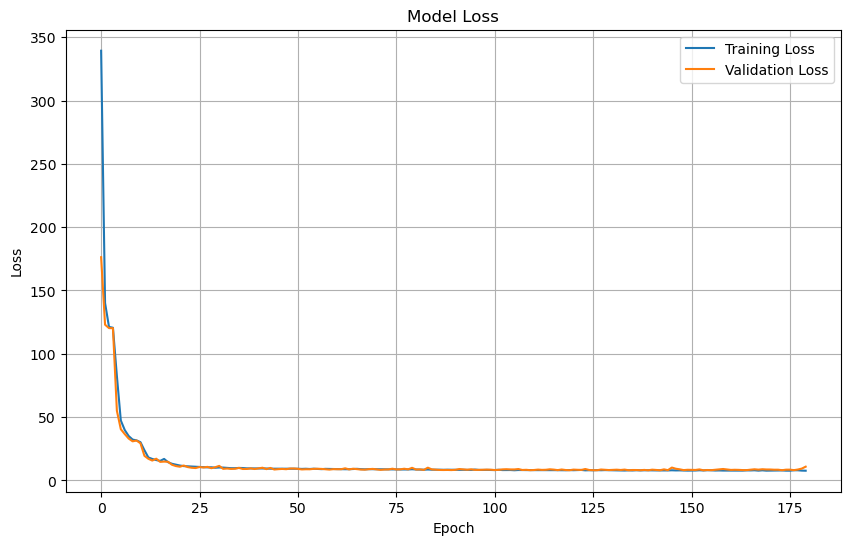

In [24]:
############################################################
# 6) DEFINE MODEL
############################################################

num_features = X_train.shape[2]
max_len_in   = X_train.shape[1]
max_len_out  = Y_train.shape[1]

latent_dim = 64  
model_input = keras.Input(shape=(max_len_in, num_features))

x = layers.Masking(mask_value=0.0)(model_input)  # ignores padded input
x = layers.LSTM(latent_dim, return_sequences=False)(x)  # encoder
x = layers.RepeatVector(max_len_out)(x)
x = layers.LSTM(latent_dim, return_sequences=True)(x)   # first decoder layer
x = layers.LSTM(latent_dim, return_sequences=True)(x)   # second decoder layer (added hidden layer)
output = layers.TimeDistributed(layers.Dense(2))(x)

model = keras.Model(model_input, output)
model.compile(optimizer='adam', loss='mse')
model.summary()

############################################################
# 7) TRAIN WITH MASKED SAMPLE_WEIGHT
############################################################

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)

# Optionally switch to Huber or MAE if you like:
# model.compile(optimizer='adam', loss='huber')

history = model.fit(
    X_train,
    Y_train,
    sample_weight=train_sw,               # shape (batch, T)
    epochs=400,
    batch_size=32,
    validation_data=(X_val, Y_val, val_sw),
    callbacks=[early_stop]
)

############################################################
# 8) EVALUATE
############################################################

test_loss = model.evaluate(X_test, Y_test, sample_weight=test_sw)
print("Test loss (MSE ignoring padded frames):", test_loss)









In [37]:
import pandas as pd

# Create a DataFrame to store the final results
results_data = {
    "Metric": ["Test Loss (MSE ignoring padded frames)"],
    "Value": [test_loss]
}

# Convert the dictionary to a DataFrame
results_df = pd.DataFrame(results_data)

# Save the DataFrame to a CSV file for Kaggle upload
results_df.to_csv('results_for_kaggle.csv', index=False)

import kaggle

# Load the CSV file from the current directory
results_df_kaggle = pd.read_csv('results_for_kaggle.csv')

# Display the DataFrame
print(results_df_kaggle)


In [35]:
############################################################
# 9) VISUALIZE LOSS
############################################################

import plotly.graph_objects as go

# Create a figure
fig = go.Figure()

# Add training loss trace
fig.add_trace(go.Scatter(
    x=list(range(len(history.history['loss']))),
    y=history.history['loss'],
    mode='lines',
    name='Training Loss',
    line=dict(width=2, color='blue')
))

# Add validation loss trace
fig.add_trace(go.Scatter(
    x=list(range(len(history.history['val_loss']))),
    y=history.history['val_loss'],
    mode='lines',
    name='Validation Loss',
    line=dict(width=2, color='orange')
))

# Update layout with titles and log scales
fig.update_layout(
    title='Model Loss Over Epochs',
    xaxis=dict(title='Epoch (Log Scale)', type='log', tickvals=[1, 10, 100]),
    yaxis=dict(title='Loss (Log Scale)', type='log', tickvals=[10, 100]),
    template='simple_white',
    legend=dict(x=0.8, y=0.9)
)

# Show the figure
fig.show()

In [28]:
# Save the trained model to a file using the recommended Keras format
model.save('trained_route_model_v4.keras')


# v2 - 10.308198928833008

2025-01-06 00:27:54,418 - DEBUG - Creating converter from 5 to 3


In [10]:
# Save the trained model to a file using the recommended Keras format
model.save('trained_route_model_v4.keras')

In [7]:
from keras.models import load_model

# Load the trained model from the file
model = load_model('trained_route_model_v3.keras', compile=False)


In [44]:
import plotly.graph_objects as go
import numpy as np
import pandas as pd

# Load additional data
players_df = pd.read_csv('Data/players.csv')
plays_df = pd.read_csv('Data/plays.csv')

# Function to visualize a single receiver's path with animation
def visualize_receiver_path(gameId, playId, nflId, df, model, feature_cols, max_len_in):
    """
    Visualize the path of a single wide receiver before snap, actual path after snap,
    and predicted path after snap on an NFL field with animation.
    Parameters:
    - gameId: ID of the game
    - playId: ID of the play
    - nflId: ID of the wide receiver
    - df: The preprocessed DataFrame
    - model: Trained Keras model
    - feature_cols: List of feature column names
    - max_len_in: Maximum length of the input sequence during training (the original 'max_len_in')
    """
    # Filter the DataFrame for the specific play and receiver
    play_receiver_df = df[(df['gameId'] == gameId) &
                          (df['playId'] == playId) &
                          (df['nflId'] == nflId)]

    if play_receiver_df.empty:
        print("No data found for the specified gameId, playId, and nflId.")
        return

    # Sort by frameId
    play_receiver_df = play_receiver_df.sort_values('frameId')

    # Identify frames before and at snap
    before_snap_df = play_receiver_df[
        play_receiver_df['frameType'].isin(['BEFORE_SNAP', 'SNAP'])]
    after_snap_df = play_receiver_df[
        ~play_receiver_df['frameType'].isin(['BEFORE_SNAP', 'SNAP'])]

    if before_snap_df.empty:
        print("No BEFORE_SNAP or SNAP frames found for this receiver.")
        return

    # Prepare input sequence using only frames before and at snap
    X_sequence = before_snap_df[feature_cols].astype(float).values
    X_sequence = np.expand_dims(X_sequence, axis=0)  # Model expects batch dimension

    # Pad X_sequence to match max_len_in
    X_sequence_padded = np.zeros((1, max_len_in, X_sequence.shape[2]))
    X_sequence_padded[0, :X_sequence.shape[1], :] = X_sequence[0]

    # Use padded sequence for prediction
    Y_pred = model.predict(X_sequence_padded)[0]  # Remove batch dimension

    # Actual Y sequence
    Y_actual = after_snap_df[['x', 'y']].values

    # Define maximum output length based on the model's output
    max_len_out = Y_pred.shape[0]

    # If Y_pred is shorter than Y_actual, pad Y_pred
    if Y_pred.shape[0] < Y_actual.shape[0]:
        pad_length = Y_actual.shape[0] - Y_pred.shape[0]
        Y_pred = np.vstack([Y_pred, np.zeros((pad_length, 2))])
    elif Y_pred.shape[0] > Y_actual.shape[0]:
        Y_pred = Y_pred[:Y_actual.shape[0], :]

    # Use actual and predicted coordinates without shifting
    Y_actual_shifted = Y_actual
    Y_pred_shifted = Y_pred
    before_snap_coords = before_snap_df[['x', 'y']].values

    # Get player name and team information
    player_name = players_df.loc[players_df['nflId'] == nflId, 'displayName'].values[0]
    play_info = plays_df[(plays_df['gameId'] == gameId) & (plays_df['playId'] == playId)]
    possession_team = play_info['possessionTeam'].values[0]
    defensive_team = play_info['defensiveTeam'].values[0]

    # Create the field plot
    fig = create_nfl_field()

    # Initialize traces for before snap, actual path, and predicted path
    before_snap_trace = go.Scatter(
        x=before_snap_coords[:, 0],
        y=before_snap_coords[:, 1],
        mode='markers+lines',
        name='Before Snap',
        line=dict(color='orange', width=2),
        opacity=0.8,
        marker=dict(size=6)
    )
    fig.add_trace(before_snap_trace)

    # Initialize empty traces for Actual Path and Predicted Path
    actual_path_trace = go.Scatter(
        x=[],
        y=[],
        mode='markers+lines',
        name='Actual Path',
        line=dict(color='cyan', width=2),
        opacity=0.8,
        marker=dict(size=6)
    )
    predicted_path_trace = go.Scatter(
        x=[],
        y=[],
        mode='markers+lines',
        name='Predicted Path',
        line=dict(color='magenta', width=2, dash='dash'),
        opacity=0.8,
        marker=dict(size=6)
    )
    fig.add_trace(actual_path_trace)
    fig.add_trace(predicted_path_trace)

    # Create frames for animation
    frames = []
    total_steps = max(len(Y_actual_shifted), len(Y_pred_shifted))
    for step in range(1, total_steps + 1):
        frame_actual = Y_actual_shifted[:step]
        frame_pred = Y_pred_shifted[:step]

        frames.append(go.Frame(
            data=[
                go.Scatter(
                    x=before_snap_coords[:, 0],
                    y=before_snap_coords[:, 1],
                    mode='markers+lines',
                    line=dict(color='orange', width=2),
                    marker=dict(size=6)
                ),
                go.Scatter(
                    x=frame_actual[:, 0],
                    y=frame_actual[:, 1],
                    mode='markers+lines',
                    line=dict(color='cyan', width=2),
                    marker=dict(size=6)
                ),
                go.Scatter(
                    x=frame_pred[:, 0],
                    y=frame_pred[:, 1],
                    mode='markers+lines',
                    line=dict(color='magenta', width=2, dash='dash'),
                    marker=dict(size=6)
                )
            ],
            name=str(step)
        ))

    # Add frames to the figure
    fig.frames = frames

    # Define animation settings
    fig.update_layout(
        title=f"Receiver Path for {player_name}: {possession_team} vs. {defensive_team}",
        legend=dict(x=0.7, y=1),
        updatemenus=[
            dict(
                type="buttons",
                showactive=False,
                y=1,
                x=1.05,
                xanchor="right",
                yanchor="top",
                pad=dict(t=0, r=10),
                buttons=[
                    dict(
                        label="Play",
                        method="animate",
                        args=[
                            None,
                            dict(frame=dict(duration=100, redraw=True),
                                 transition=dict(duration=0),
                                 fromcurrent=True,
                                 mode='immediate')
                        ]
                    ),
                    dict(
                        label="Pause",
                        method="animate",
                        args=[
                            [None],
                            dict(frame=dict(duration=0, redraw=False),
                                 transition=dict(duration=0),
                                 mode='immediate')
                        ]
                    )
                ]
            )
        ],
        sliders=[
            dict(
                steps=[
                    dict(
                        method='animate',
                        args=[
                            [str(k)],
                            dict(mode='immediate',
                                 frame=dict(duration=100, redraw=True),
                                 transition=dict(duration=0))
                        ],
                        label=str(k)
                    ) for k in range(1, total_steps + 1)
                ],
                transition=dict(duration=0),
                x=0,
                y=0,
                currentvalue=dict(font=dict(size=12), prefix='Frame: ', visible=True, xanchor='center'),
                len=1.0
            )
        ],
        template='simple_white'
    )

    fig.show()


# Function to plot the NFL field (updated)
def create_nfl_field():
    # NFL field dimensions in yards
    field_length = 120  # Including end zones
    field_width = 53.3

    fig = go.Figure()

    # Add the field outline
    fig.add_shape(type="rect",
                  x0=0,
                  y0=0,
                  x1=field_length,
                  y1=field_width,
                  line=dict(color="green", width=2))

    # Add end zones
    fig.add_shape(type="rect",
                  x0=0,
                  y0=0,
                  x1=10,
                  y1=field_width,
                  line=dict(color="blue", width=2),
                  fillcolor="blue",
                  opacity=0.2)
    fig.add_shape(type="rect",
                  x0=110,
                  y0=0,
                  x1=120,
                  y1=field_width,
                  line=dict(color="blue", width=2),
                  fillcolor="blue",
                  opacity=0.2)

    # Add yard lines and numbers
    for yard in range(10, 110, 10):
        fig.add_shape(type="line",
                      x0=yard,
                      y0=0,
                      x1=yard,
                      y1=field_width,
                      line=dict(color="white", width=1, dash='dash'))
        # Add yard numbers only between the end zones
        if 20 <= yard <= 50:
            fig.add_annotation(x=yard,
                               y=field_width / 2,
                               text=str(yard - 10),
                               showarrow=False,
                               font=dict(color="white", size=12))
        elif 60 <= yard <= 100:
            fig.add_annotation(x=yard,
                               y=field_width / 2,
                               text=str(110 - yard),
                               showarrow=False,
                               font=dict(color="white", size=12))

    # Update layout
    fig.update_layout(width=800,
                      height=500,
                      plot_bgcolor="darkgreen",
                      xaxis=dict(range=[-5, 125],
                                 showgrid=False,
                                 zeroline=False,
                                 visible=False),
                      yaxis=dict(range=[-5, 58.3],
                                 showgrid=False,
                                 zeroline=False,
                                 visible=False),
                      )
    return fig


# Example usage (assuming you have defined X_train, df, model, feature_cols)
# Plot random 10 routes

import random

# Retrieve the original 'max_len_in' used during training
max_len_in = X_train.shape[1]

# Get unique combinations of gameId, playId, and nflId
unique_combinations = df[['gameId', 'playId', 'nflId']].drop_duplicates()

# Randomly select 10 unique combinations
random_combinations = unique_combinations.sample(n=10)

# Plot each randomly selected play
for _, row in random_combinations.iterrows():
    visualize_receiver_path(gameId=row['gameId'],
                            playId=row['playId'],
                            nflId=row['nflId'],
                            df=df,
                            model=model,
                            feature_cols=feature_cols,
                            max_len_in=max_len_in)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
